In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

Using TensorFlow backend.
/Users/Yoav/miniconda3/envs/infovis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Yoav/miniconda3/envs/infovis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Yoav/miniconda3/envs/infovis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Yoav/minic

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [2]:
%run utils.py

In [3]:
%run models.py

In [4]:
%%time

image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
CPU times: user 26.2 s, sys: 2.91 s, total: 29.1 sing 75/117Interpolating 1/112Interpolating 39/112Interpolating 77/112Interpolating 111/112Interpolating 1/111Interpolating 24/111Interpolating 40/111Interpolating 71/111Interpolating 111/111Interpolating 1/109Interpolating 22/109Interpolating 67/109Interpolating 108/109Interpolating 1/113Interpolating 57/113Interpolating 108/113Interpolating 1/104Interpolating 56/104Interpolating 82/104Interpolating 87/104Interpolating 1/101Interpolating 56/101Interpolating 98/101Interpolating 1/102Interpolating 56/102Interpolating 1/107Interpolating 51/107Interpolating 97/107Interpolating 1/113Interpolating 47/113Interpolating 99/113Interpolating 1/115Interpolating 56/115Interpolating 106/115Interpolating 1/139Interpolating 49/139Interpolating 95/139Interpolating 1/123Interpolating 57/123Interpolating 108/123Interpolating 1/118Interpolating 51/118Interpolating 102/118Interpolating 1/120Interpolating 58/120Interpolating 105/1

In [10]:
X.shape, y.shape

((1821, 28, 28, 3), (1821,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


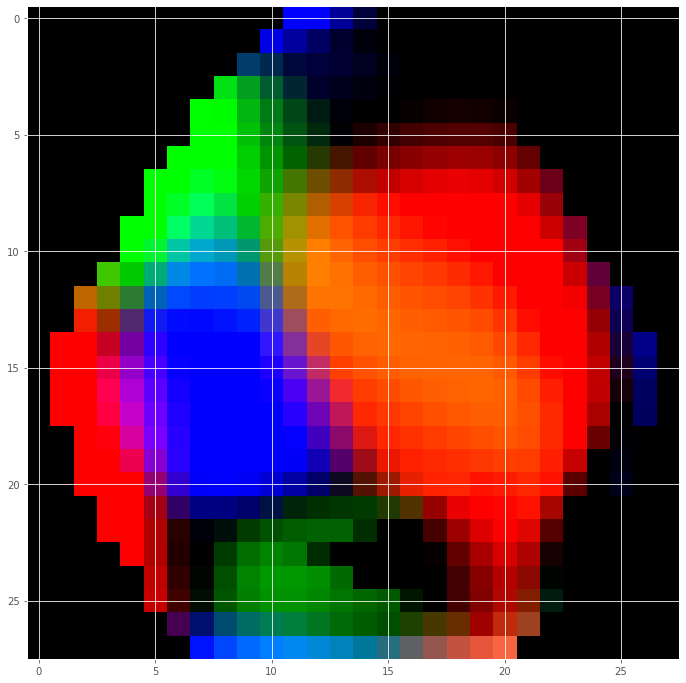

In [11]:
plt.imshow(X[3])

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [13]:
y_train.shape

(1456,)

In [14]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (1456, 28, 28, 3)
1456 train samples
365 test samples


### Train Original Model

In [15]:
batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)


model = get_func_model_1(input_shape, num_classes)
# model = get_model_2(input_shape, num_classes)


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

In [17]:
%%time

history = model.fit(x_train, y_train_cat,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test_cat),
          shuffle=True, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 4s 3ms/step - loss: 0.6947 - acc: 0.5268 - val_loss: 0.6820 - val_acc: 0.6000
Epoch 2/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6867 - acc: 0.5611 - val_loss: 0.6740 - val_acc: 0.6219
Epoch 3/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6760 - acc: 0.6010 - val_loss: 0.6685 - val_acc: 0.6137
Epoch 4/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6662 - acc: 0.6113 - val_loss: 0.6675 - val_acc: 0.5945
Epoch 5/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6591 - acc: 0.6319 - val_loss: 0.6575 - val_acc: 0.6137
Epoch 6/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6512 - acc: 0.6174 - val_loss: 0.6546 - val_acc: 0.6466
Epoch 7/200
1456/1456 [==========================

1456/1456 [==============================] - 3s 2ms/step - loss: 0.3758 - acc: 0.8516 - val_loss: 0.5222 - val_acc: 0.7589
Epoch 59/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.3658 - acc: 0.8441 - val_loss: 0.5195 - val_acc: 0.7589
Epoch 60/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.3664 - acc: 0.8585 - val_loss: 0.5512 - val_acc: 0.7288
Epoch 61/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.3665 - acc: 0.8482 - val_loss: 0.5187 - val_acc: 0.7726
Epoch 62/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.3587 - acc: 0.8585 - val_loss: 0.5613 - val_acc: 0.7397
Epoch 63/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.3570 - acc: 0.8626 - val_loss: 0.5357 - val_acc: 0.7507
Epoch 64/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.3512 - acc: 0.8551 - val_loss: 0.5271 - val_acc: 0.7753
Epoch 65/200
1456/1456 [==============================] - 2s 

1456/1456 [==============================] - 2s 1ms/step - loss: 0.2133 - acc: 0.9231 - val_loss: 0.5661 - val_acc: 0.7753
Epoch 119/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2103 - acc: 0.9272 - val_loss: 0.5568 - val_acc: 0.7836
Epoch 120/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2119 - acc: 0.9265 - val_loss: 0.5741 - val_acc: 0.7671
Epoch 121/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.2113 - acc: 0.9231 - val_loss: 0.5782 - val_acc: 0.7781
Epoch 122/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.2065 - acc: 0.9279 - val_loss: 0.5663 - val_acc: 0.7781
Epoch 123/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.1979 - acc: 0.9375 - val_loss: 0.6071 - val_acc: 0.7726
Epoch 124/200
1456/1456 [==============================] - 4s 3ms/step - loss: 0.2055 - acc: 0.9299 - val_loss: 0.5665 - val_acc: 0.7699
Epoch 125/200
1456/1456 [==============================

Epoch 178/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1236 - acc: 0.9636 - val_loss: 0.7079 - val_acc: 0.7808
Epoch 179/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1159 - acc: 0.9677 - val_loss: 0.6734 - val_acc: 0.7808
Epoch 180/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1173 - acc: 0.9691 - val_loss: 0.6689 - val_acc: 0.7945
Epoch 181/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1150 - acc: 0.9670 - val_loss: 0.6713 - val_acc: 0.7781
Epoch 182/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1128 - acc: 0.9670 - val_loss: 0.7181 - val_acc: 0.7452
Epoch 183/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1151 - acc: 0.9663 - val_loss: 0.6952 - val_acc: 0.7781
Epoch 184/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.1094 - acc: 0.9718 - val_loss: 0.7044 - val_acc: 0.7753
Epoch 185/200
1456/1456 [================

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                62730     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total para

In [13]:
model.layers

In [18]:
model.save('models/model_2.h5')

In [19]:
predictions_base_model = model.predict(X)
predictions_base_model.shape

(1821, 2)

In [20]:
predictions_base_model

array([[3.4503936e-04, 9.9965501e-01],
       [2.1045016e-02, 9.7895491e-01],
       [1.7873488e-03, 9.9821270e-01],
       ...,
       [8.9528030e-01, 1.0471968e-01],
       [8.7062722e-01, 1.2937282e-01],
       [6.5833932e-01, 3.4166068e-01]], dtype=float32)

### CAM 2.0

In [5]:
import tensorflow as tf
import keras.backend as K
from keras.layers.core import Lambda
from keras.models import Sequential
import numpy as np
from keras.models import load_model
 


In [6]:
# load model
model = load_model('models/model_2.h5')








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [44]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def naive_cam(input_model, image, category_index, layer_name):
    conv_output = [l for l in model.layers if l.name == layer_name][0].output 
    cam_extractor = K.function([model.input], [conv_output])
    cam = cam_extractor([image[None]])
    cam = cam[0][0]
    cam = np.maximum(cam, 0)
    cam = np.sum(cam, axis=2)
    heatmap = cam / np.max(cam)
    return cam, heatmap

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 2
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    last = Lambda(target_layer, output_shape=target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=last)
    loss = K.sum(model.layers[-1].output)
    conv_output = [l for l in model.layers if l.name == layer_name][0].output 
    grads = normalize(K.gradients(loss, conv_output)[0])
    
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    
    output, grads_val = gradient_function([image[None]])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    return cam, heatmap

In [38]:
cam_n, heatmap_n = naive_cam(model, X[0], 0, 'conv2d_2')

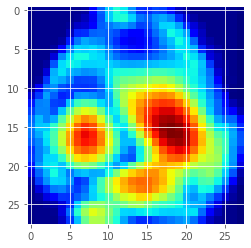

In [40]:
plt.imshow(heatmap_n, cmap='jet')
plt.show()

(1, 28, 28, 32)


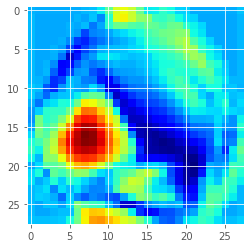

In [41]:
predictions = model.predict(X)
predicted_class = np.argmax(predictions[0])
cam, heatmap = grad_cam(model, X[0], predicted_class, 'conv2d_2')
plt.imshow(cam, cmap='jet')
plt.show()

## Visualize CAMs

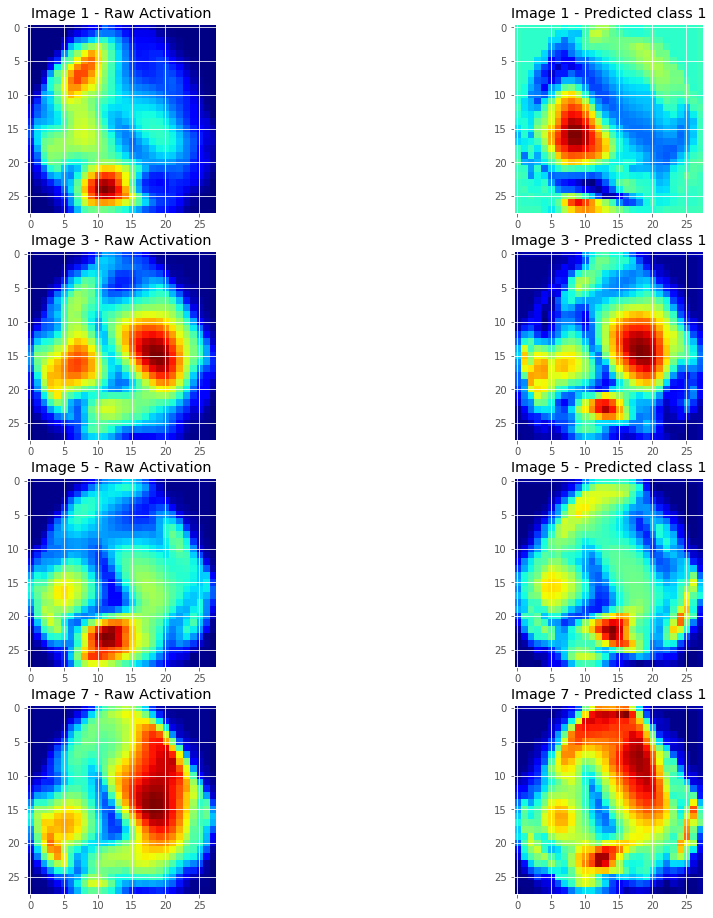

In [51]:
    
fig= plt.figure(figsize=(16, 16))
columns = 2
rows = 4
for i in range(1, columns * rows + 1, columns):
    #cam0, heatmap0 = grad_cam(model, X[i], 0, 'conv2d_2')
    #fig.add_subplot(rows, columns, i)
    #plt.imshow(cam0, cmap='jet')
    #plt.title(f'Image {i} - class {0}')
    
    cam_n, heatmap_n = naive_cam(model, X[i], 0, 'conv2d_2')
    fig.add_subplot(rows, columns, i)
    plt.imshow(cam_n, cmap='jet')
    plt.title(f'Image {i} - Raw Activation')
    
    predicted_class = np.argmax(predictions[0])
    
    cam1, heatmap1 = grad_cam(model, X[i], predicted_class, 'conv2d_2')
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(cam1, cmap='jet')
    plt.title(f'Image {i} - Predicted class {predicted_class}')
    
plt.show()